# 2. Visualize results of stochastic simulation

In [1]:
import sys
if '/' in sys.path[0]:
    sys.path.append('/home/elisa/PycharmProjects/gempy')
elif '\\' in sys.path[0]:
    sys.path.append('C:\\users\\elisa\\documents\\git\\gempy')

In [2]:
#import warnings
#warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pn
#import mplstereonet
import gempy as gp
from matplotlib.ticker import FixedFormatter, FixedLocator
from gempy.plot import helpers
import matplotlib.colors as mcolors

C:\Users\elisa\Anaconda3\envs\gempy_n\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\elisa\Anaconda3\envs\gempy_n\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implemen

Active grids: ['regular']
Active grids: ['regular' 'topography' 'sections']


Grid Object. Values: 
array([[   5.        ,    5.        ,    5.        ],
       [   5.        ,    5.        ,   15.        ],
       [   5.        ,    5.        ,   25.        ],
       ...,
       [1000.        ,  200.        ,  974.6835443 ],
       [1000.        ,  200.        ,  987.34177215],
       [1000.        ,  200.        , 1000.        ]])

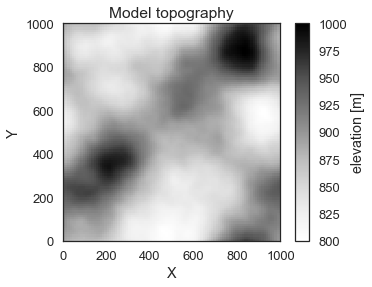

In [20]:
mode = '3Dblock'
# I subdivide into map and 3d block because otherwhise the arrays become too big
# which results in a memory error

if mode == '3Dblock':
    resolution = [100,100,100]
elif mode == 'map':
    resolution = [5,5,5]
    
geo_model = gp.create_model('simplemodel')
# to speed up the computation, the 3d resolution is pretty low here.
# for comparison, use 2d slice of section s1 and topography.
gp.init_data(geo_model, extent=[0,1000,0,1000,0,1000],resolution = resolution,
                         path_i = "faultuncertainty_interfaces_surface.csv",
                         path_o = "faultuncertainty_orient_surface.csv")

gp.map_series_to_surfaces(geo_model, {'fault_series':'fault','form_series':('layer1','layer2','basement')})
geo_model.surfaces.colors.change_colors({'layer1': '#ffbe00', 'layer2': '#9f0052', 'fault': '#015482',
                                        'basement': '#728f02'})

geo_model.set_is_fault(['fault_series'],change_color=False)

#if mode == 'map':
geo_model.grid.set_section_grid({'s1':([0,200],[1000,200],[80,80])})#p1,p2,resolution
geo_model.set_topography(source='saved', filepath='topo.npy')

In [21]:
from gempy.plot import visualization_2d
plot = visualization_2d.PlotSolution(geo_model)

In [33]:
from matplotlib.ticker import FixedFormatter, FixedLocator
from gempy.plot import helpers

def plot_probabilities(plot, block, shape, T = False, extent=None):
    fig, ax = plt.subplots(int(np.ceil(block.shape[0]/2)), 2, figsize=(20, 20))
    ax = ax.flatten()
    print(int(np.ceil(block.shape[0]/2)))
    print(block.shape)
    for i in range(block.shape[0]):
        allcolors = list(plot._color_lot.values())[plot.model.faults.n_faults:]
        formnames = list(plot._color_lot.keys())[plot.model.faults.n_faults:]
        c2 = allcolors[i]
        title = formnames[i]
        cmap = mcolors.LinearSegmentedColormap.from_list('c',['#FFFFFF',c2])
        if T:
            plotblock = block[i].reshape(shape).T
        else:
            plotblock = block[i].reshape(shape)
        im = ax[i].imshow(plotblock, origin='lower', cmap=cmap,
                    extent = extent)
        ax[i].set_title(title)
        helpers.add_colorbar(im, label='probability')
    fig.tight_layout()
    
def calculate_ie_masked(prob):
    ie = np.zeros_like(prob[0])
    for l in prob:
        pm = np.ma.masked_equal(l, 0)  # mask where prob is 0
        ie -= (pm * np.ma.log2(pm)).filled(0)
    return ie

def plot_section_by_name(self, section_name, image=None, show_data=True, show_faults=True, show_topo=True,
                         show_all_data=False, cmap='viridis', label='cell entropy', title=None, **kwargs):
    assert type(section_name) == str, 'section name must be a string of the name of the section'
    #assert self.model.solutions.sections is not None, 'no sections for plotting defined'

    j = np.where(self.model.grid.sections.names == section_name)[0][0]
    l0, l1 = self.model.grid.sections.get_section_args(section_name)
    shape = self.model.grid.sections.resolution[j]
    if image is None:
        image = self.model.solutions.sections[0][0][l0:l1].reshape(shape[0], shape[1]).T
    else: image = image.reshape(shape[0], shape[1]).T
    extent = [0, self.model.grid.sections.dist[j][0],
              self.model.grid.regular_grid.extent[4], self.model.grid.regular_grid.extent[5]]


    if show_data:
        self.plot_section_data(section_name=section_name, show_all_data=show_all_data, **kwargs)

    axes = plt.gca()
    im=axes.imshow(image, origin='lower', zorder=-100,
                cmap=cmap, extent=extent)
    if show_faults:
        self.extract_section_fault_lines(section_name, axes)

    if show_topo:
        if self.model.grid.topography is not None:
            alpha = kwargs.get('alpha', 1)
            xy = self.make_topography_overlay_4_sections(j)
            axes.fill(xy[:, 0], xy[:, 1], 'k', zorder=10, alpha=alpha)

    labels, axname = self._make_section_xylabels(section_name, len(axes.get_xticklabels()) - 2)
    pos_list = np.linspace(0, self.model.grid.sections.dist[j], len(labels))
    axes.xaxis.set_major_locator(FixedLocator(nbins=len(labels), locs=pos_list))
    axes.xaxis.set_major_formatter(FixedFormatter((labels)))
    if title is None:
        title=self.model.grid.sections.names[j]
    axes.set(title=title, xlabel=axname, ylabel='Z')
    helpers.add_colorbar(im, label=label)

#### 1. Sections

In [68]:
prop_section=np.load(r'results/prob_sections_faultsonly_or100.npy')
section_ie = calculate_ie_masked(prop_section)

2
(3, 6400)


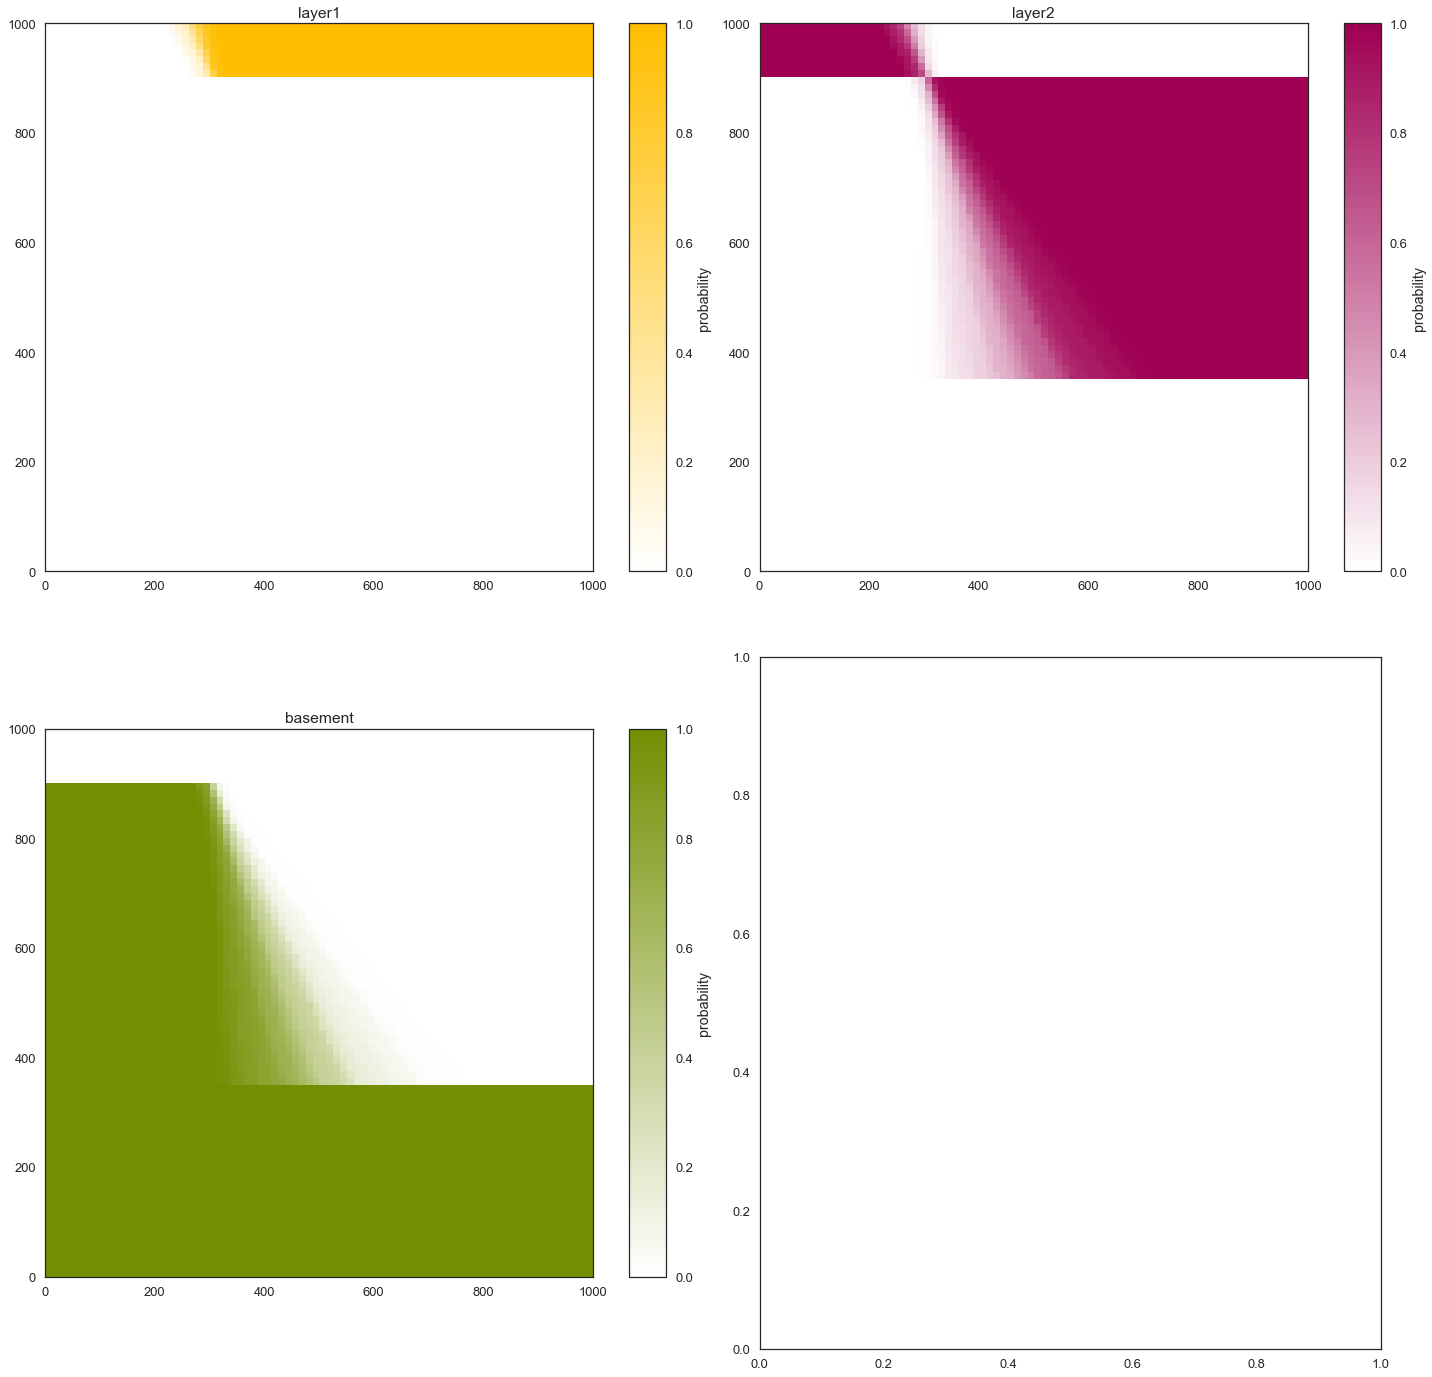

In [70]:
plot_probabilities(plot, prop_section, geo_model.grid.sections.resolution[0],
                  T=True, extent=[0,1000,0,1000])
#plt.savefig('probability_plot_lith.svg')

In [56]:
allcolors = list(plot._color_lot.values())[plot.model.faults.n_faults:]
formnames = list(plot._color_lot.keys())[plot.model.faults.n_faults:]
cm_list=[]
title_list=[]
for i in range(len(formnames)):
    c2 = allcolors[i]
    title = formnames[i]
    title_list.append(title)
    cmap = mcolors.LinearSegmentedColormap.from_list('c',['#FFFFFF',c2])
    cm_list.append(cmap)

In [57]:
section_ie

array([0., 0., 0., ..., 0., 0., 0.])

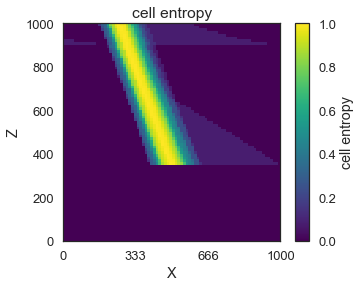

In [59]:
plot_section_by_name(plot, 's1', image = section_ie, cmap='viridis', show_data=False, show_faults=False,
                    label='cell entropy', title='cell entropy', show_topo=False)
#plt.savefig('entropoy_plot_lith.svg')

In [62]:
cm_list

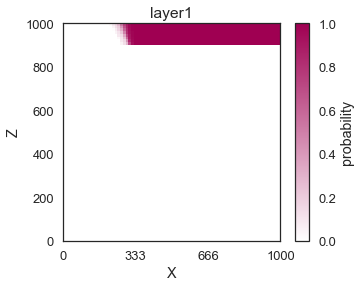

In [73]:
i = 0
plot_section_by_name(plot, 's1', image = prop_section[i], cmap=cm_list[1], show_data=False, show_faults=False,
                    label='probability', title=title_list[i], show_topo=False)
plt.savefig('layer_1_plot_or.svg')

#### 2. Map

In [23]:
probmap=np.load(r'results/prob_map_faultsonly.npy')
block_ie = calculate_ie_masked(probmap)

2
(3, 2500)


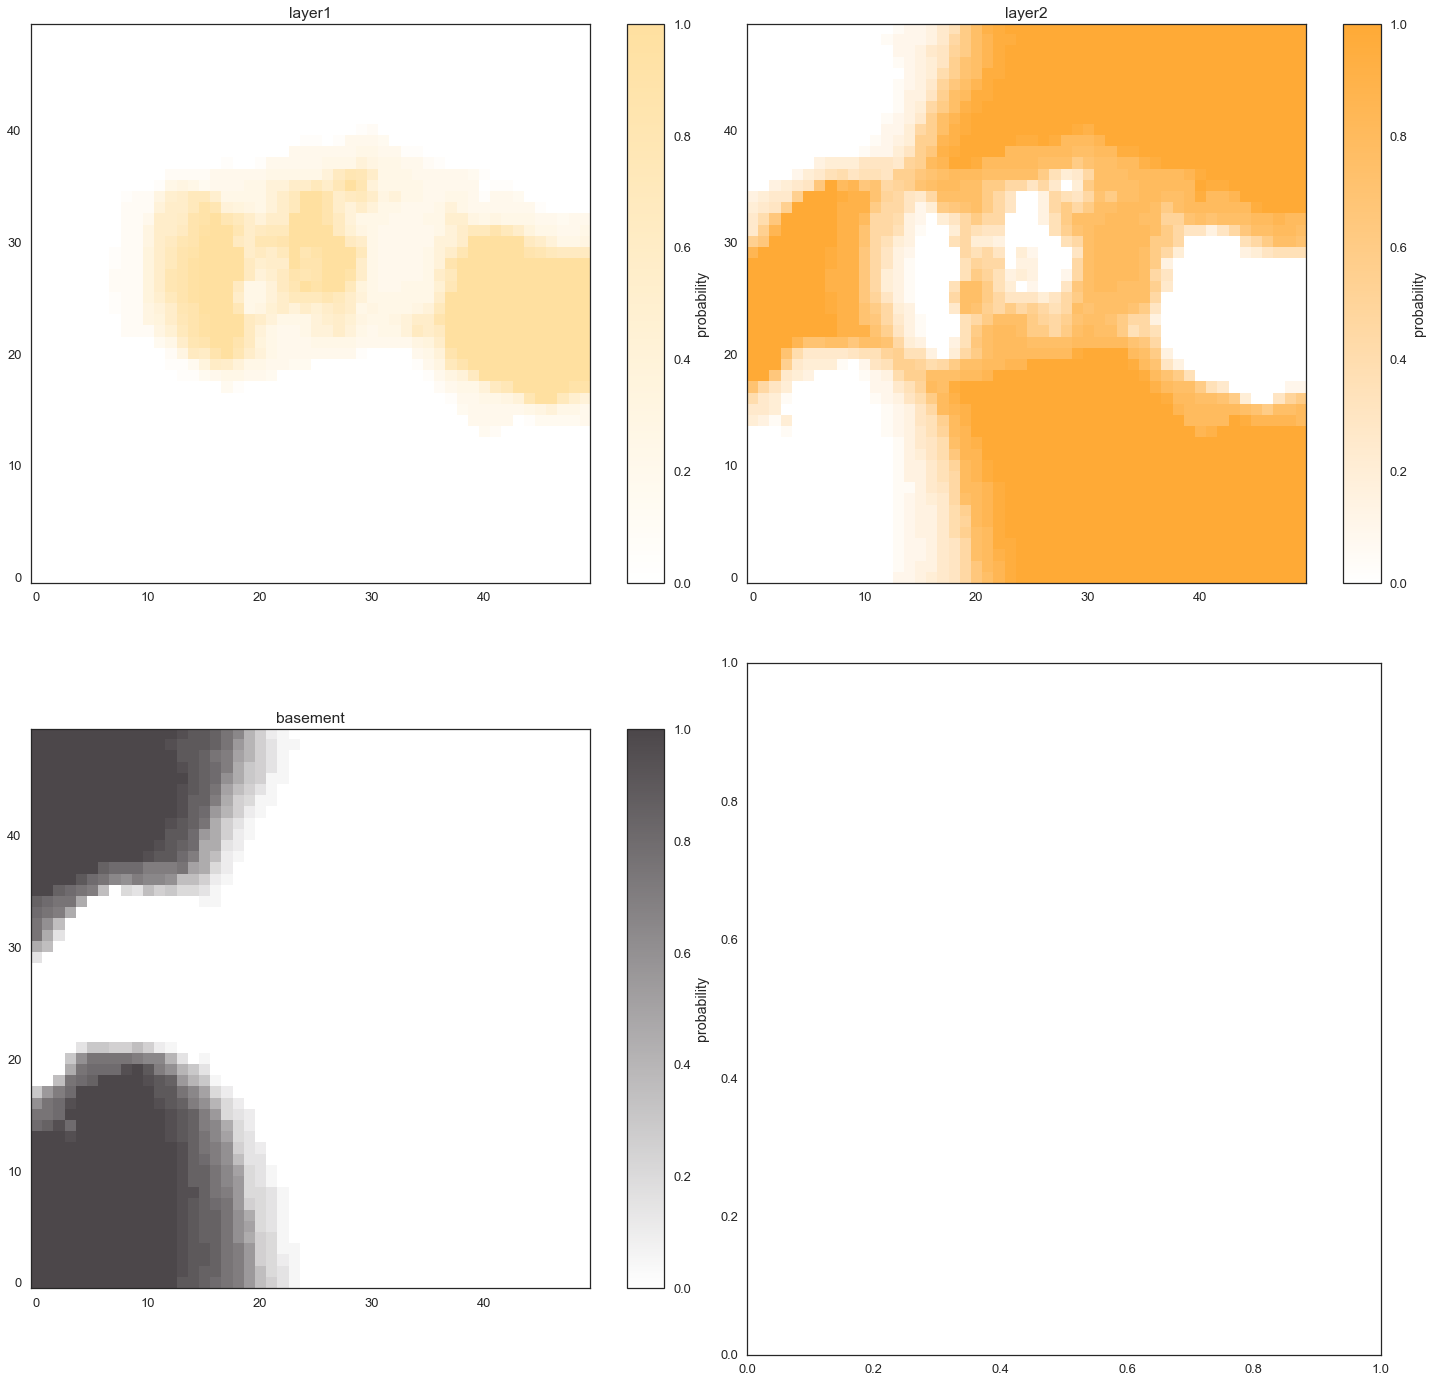

In [24]:
plot_probabilities(plot, probmap, geo_model.grid.topography.resolution,
                  T=False)

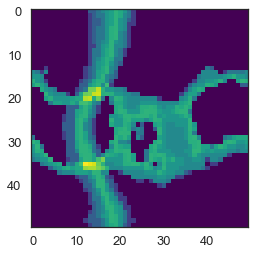

In [25]:
plt.imshow(block_ie.reshape(geo_model.grid.topography.resolution), cmap='viridis')

#### 3. 3-D block

In [28]:
probblock=np.load(r'results/prob_block_faultsonly.npy')
block_ie = calculate_ie_masked(probblock).reshape(20,20,20)

In [29]:
import pyvista as pv

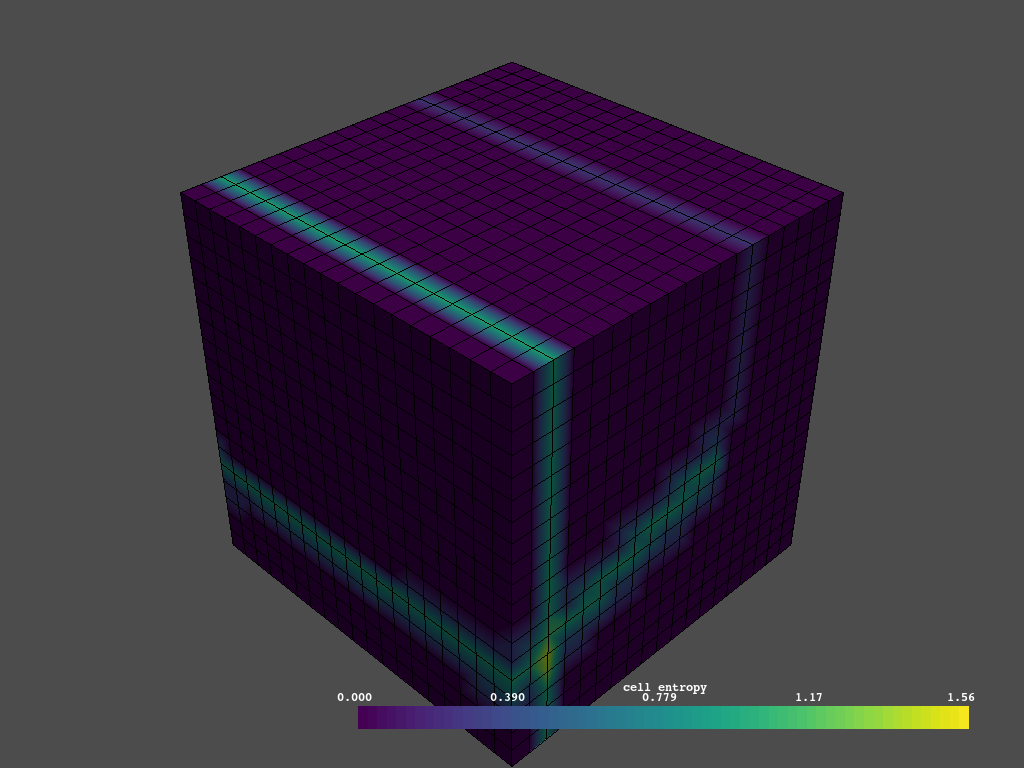

In [31]:
grid = pv.UniformGrid()
grid.dimensions = block_ie.shape
grid.point_arrays["cell entropy"] = block_ie.flatten() 
grid.plot(show_edges=True)